In [1]:
ours2orig = [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 254, 41, 42, 43, 44, 45,
46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64,
65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 85,
86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103,
104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 136, 138, 132,
133, 134, 135, 220, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 185, 186,
187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201,
202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216,
217, 218, 219, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232,
233, 137, 234, 235, 236, 237, 238, 239, 240, 241, 250, 251, 255, 256, 257,
258, 259, 260, 261, 262, 263, 242, 243, 244, 245, 0, 1, 2, 3, 4, 5, 6, 7, 8,
9, 10, 11, 83, 84, 131, 139, 140, 141, 181, 182, 183, 184, 246, 247, 248,
249, 252, 253]

def vec2mat(v):
    a,b = np.triu_indices(264,1)
    m = np.zeros((264,264))
    m[a,b] = v
    return m+m.T

def remap(fc, roimap=ours2orig):
    fc = fc[roimap,:]
    fc = fc[:,roimap]
    return fc

print('Complete')

Complete


In [53]:
import pickle
import numpy as np

# s1.0 = male probably

bsnipdir = '/home/anton/Documents/Tulane/Research/data-sav/anton/cohorts/BSNIP/'
demo = pickle.load(open(f'{bsnipdir}/demographics.pkl', 'rb'))

fc = []
race = []
sex = []
age = []
sz = []

a,b = np.triu_indices(264,1)

for sub in demo['Age_cal']:
    diag = demo['DXGROUP_1'][sub]
    if diag not in ['SZP', 'NC']:
        continue
    ra = demo['Race'][sub]
    if ra not in ['AA', 'CA']:
        continue
    se = demo['sex'][sub]
    diag = diag == 'SZP'
    ra = ra == 'AA'
    se = se == 's1.0'
    ag = demo['Age_cal'][sub]
    p = np.load(f'{bsnipdir}/fc/{sub}_task-unk_fc.npy')
    p = remap(vec2mat(p))[a,b]
    age.append(ag)
    sex.append(se)
    race.append(ra)
    sz.append(diag)
    fc.append(p)

fc = np.stack(fc)
race = np.array(race).astype('int')
sex = np.array(sex).astype('int')
sz = np.array(sz).astype('int')
age = np.array(age)

print(max(age))
print(min(age))
print(np.mean(age))
print(np.std(age))
age = (age-np.mean(age))/np.std(age)

print([a.shape for a in [fc, sz, race, sex, age]])

64.0
15.0
36.92098765432099
12.335582538145621
[(405, 34716), (405,), (405,), (405,), (405,)]


In [57]:
from sklearn.linear_model import Ridge, LogisticRegression
import torch

age_reg = Ridge(alpha=100).fit(fc, age)
age_w = torch.from_numpy(age_reg.coef_).float().cuda()
age_i = age_reg.intercept_
sex_reg = LogisticRegression(C=100, max_iter=500).fit(fc, sex)
sex_w = torch.from_numpy(sex_reg.coef_[0]).float().cuda()
sex_i = sex_reg.intercept_[0]
race_reg = LogisticRegression(C=100, max_iter=500).fit(fc, race)
race_w = torch.from_numpy(race_reg.coef_[0]).float().cuda()
race_i = race_reg.intercept_[0]
sz_reg = LogisticRegression(C=100, max_iter=500).fit(fc, sz)
sz_w = torch.from_numpy(sz_reg.coef_[0]).float().cuda()
sz_i = sz_reg.intercept_[0]

print(age_i, sex_i, race_i, sz_i)

0.8749722627654616 0.016462112803870683 0.006857627907262022 0.04760862089526853


In [58]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import random

class VAE(nn.Module):
    def __init__(self, fcd, ld, matsz, rank):
        super(VAE, self).__init__()
        self.fcd = fcd
        self.ld = ld
        self.matsz = matsz
        self.rank = rank
        self.enc1 = nn.Linear(fcd, 1000).float().cuda()
        self.enc2 = nn.Linear(1000, ld).float().cuda()
        self.dec1 = nn.Linear(ld+4, 1000).float().cuda()
        self.dec2 = nn.Linear(1000, matsz*rank).float().cuda()

    def enc(self, x):
        x = F.relu(self.enc1(x))
        z = self.enc2(x)
        return z

    def gen(self, n):
        return torch.randn(n, self.ld).float().cuda()/(10**0.5)
    
    def dec(self, z, age, sex, race, sz):
        z = torch.cat([z, age.unsqueeze(1), sex.unsqueeze(1), race.unsqueeze(1), sz.unsqueeze(1)], dim=1)
        x = F.relu(self.dec1(z))
        x = self.dec2(x)
        x = x.reshape(len(z), self.matsz, self.rank)
        x = torch.einsum('abc,adc->abd', x, x)
        return x

    def vectorize(self, x):
        a,b = np.triu_indices(self.matsz, 1)
        return x[:,a,b]

def latent_loss(z):
    C = z.T@z
    mu = torch.mean(z, dim=0)
    tgt1 = torch.eye(z.shape[-1]).float().cuda()*len(z)/10
    tgt2 = torch.zeros(z.shape[-1]).float().cuda()
    lossC = rmse(C, tgt1)
    lossmu = rmse(mu, tgt2)
    return lossC, lossmu, C, mu

def decor_loss(z, age, sex, race, sz):
    age = age - torch.mean(age)
    sex = sex - torch.mean(sex)
    race = race - torch.mean(race)
    sz = sz - torch.mean(sz)
    agep = torch.einsum('n,nz->z', age, z)
    sexp = torch.einsum('n,nz->z', sex, z)
    racep = torch.einsum('n,nz->z', race, z)
    szp = torch.einsum('n,nz->z', sz, z)
    tgt = torch.zeros(z.shape[-1]).float().cuda()
    loss_age = rmse(agep, tgt)
    loss_sex = rmse(sexp, tgt)
    loss_race = rmse(racep, tgt)
    loss_sz = rmse(szp, tgt)
    return loss_age + loss_sex + loss_race

def rmse(a, b, mean=torch.mean):
    return mean((a-b)**2)**0.5

def pretty(x):
    return f'{round(float(x), 4)}'

vae = VAE(fc.shape[-1], 30, 264, 5)
optim = torch.optim.Adam(vae.parameters(), lr=1e-4, weight_decay=0)

x = torch.from_numpy(fc).float().cuda()
age_t = torch.from_numpy(age).float().cuda()
sex_t = torch.from_numpy(sex).float().cuda()
race_t = torch.from_numpy(race).float().cuda()
sz_t = torch.from_numpy(sz).float().cuda()

nepochs = 4000
pperiod = 50

ce = nn.CrossEntropyLoss()

for e in range(nepochs):
    # Reconstruct
    optim.zero_grad()
    z = vae.enc(x)
    y = vae.dec(z, age_t, sex_t, race_t, sz_t)
    y = vae.vectorize(y)
    lossC, lossmu, _, _ = latent_loss(z)
    lossDecor = decor_loss(z, age_t, sex_t, race_t, sz_t)
    lossrec = rmse(x, y)
    # Generate
    ag = torch.ones(100).float().cuda()*torch.randn(1)[0]
    sx = torch.ones(100).long().cuda()*random.randint(0,1)
    rc = torch.ones(100).long().cuda()*random.randint(0,1)
    ss = torch.ones(100).long().cuda()*random.randint(0,1)
    z = vae.gen(100)
    y = vae.dec(z, ag, sx, rc, ss)
    y = vae.vectorize(y)
    ag_hat = y@age_w + age_i
    sx_hat = y@sex_w + sex_i
    rc_hat = y@race_w + race_i
    sz_hat = y@sz_w + sz_i
    age_loss = rmse(ag_hat, ag)
    sex_loss = ce(torch.stack([-sx_hat, sx_hat], dim=1), sx)
    race_loss = ce(torch.stack([-rc_hat, rc_hat], dim=1), rc)
    sz_loss = ce(torch.stack([-sz_hat, sz_hat], dim=1), ss)
    (lossC+lossmu+lossrec+lossDecor+0.001*age_loss+0.001*sex_loss+0.001*race_loss+0.001*sz_loss).backward()
    optim.step()
    if e%pperiod == 0 or e == nepochs-1:
        print(f'{e} {pretty(lossC)} {pretty(lossmu)} {pretty(lossDecor)} {pretty(lossrec)} {pretty(age_loss)} {pretty(sex_loss)} {pretty(race_loss)}' + 
             f' {pretty(sz_loss)}')

print('Done')

0 7.1651 0.0579 2.3497 0.3127 0.1478 0.694 0.6936 0.8793
50 7.2211 0.0513 0.2633 0.232 0.7225 0.0003 0.0 0.0038
100 7.1065 0.0517 0.4464 0.2039 0.321 0.0001 0.0051 0.0137
150 7.0033 0.0534 0.4266 0.1939 0.287 0.0025 0.0004 0.0
200 6.8768 0.0532 0.3387 0.1865 0.2073 0.0004 0.0007 0.0011
250 6.7143 0.0536 0.2732 0.1818 0.2215 0.0002 0.0002 0.0007
300 6.5487 0.0535 0.3364 0.1784 0.171 0.0025 0.0003 0.0017
350 6.3062 0.0535 0.3889 0.1759 0.2127 3.5159 0.0002 0.0003
400 6.0747 0.0544 0.2991 0.1735 0.3491 0.0 0.0013 0.0002
450 5.9026 0.0547 0.5332 0.171 0.1437 0.0001 0.002 0.0002
500 5.7114 0.0544 0.353 0.1689 0.1552 0.0001 0.0007 0.0045
550 5.5094 0.0549 0.3596 0.1669 0.1573 0.0002 0.0008 0.0082
600 5.3387 0.0546 0.2929 0.1649 0.1728 0.0013 0.0039 0.0004
650 5.1679 0.0546 0.3493 0.1631 0.1168 0.0005 0.0022 0.0004
700 4.9641 0.055 0.2819 0.1612 0.1509 0.001 0.0015 0.0021
750 4.7744 0.0554 0.2984 0.1593 0.1659 0.0002 0.0019 0.0036
800 4.607 0.0549 0.3197 0.1576 0.2031 0.0006 0.0002 0.0007
850

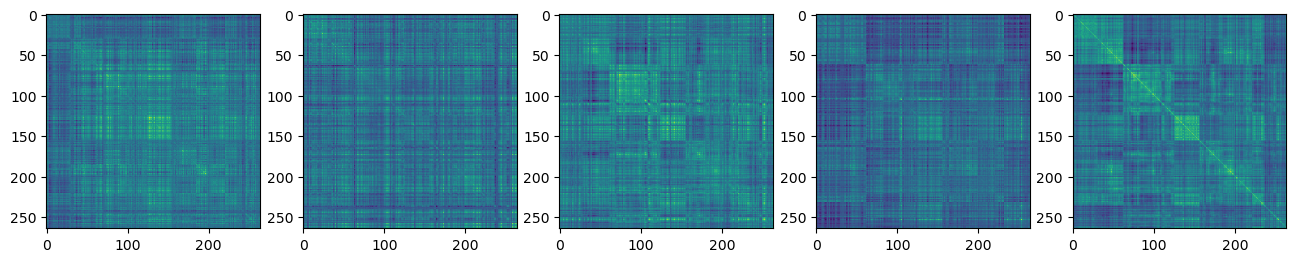

In [73]:
import matplotlib.pyplot as plt

n = 1000

with torch.no_grad():
    ag = 0*torch.ones(n).float().cuda()
    sx = 0*torch.ones(n).float().cuda()
    rc = 0*torch.ones(n).float().cuda()
    ss = 1*torch.ones(n).float().cuda()
    z = vae.gen(n)
    y = vae.dec(z, ag, sx, rc, ss)
    y = y.detach().cpu().numpy()

fig, ax = plt.subplots(1,5,figsize=(16,4))
ym = np.mean(y, axis=0)
ym2 = ym

ax[0].imshow(y[0])
ax[1].imshow(y[1])
ax[2].imshow(y[2])
ax[3].imshow(y[3])
ax[4].imshow(ym)

# fig.show()

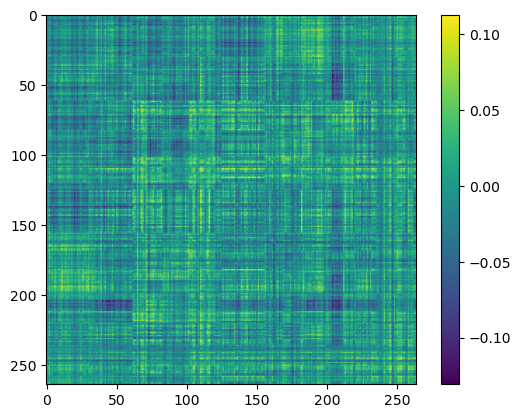

In [74]:
plt.imshow(ym2-ym1)
plt.colorbar()
plt.show()

In [68]:
# Save VAE

torch.save(vae.state_dict(), '/home/anton/Documents/Tulane/Research/ImageNomer/data/BSNIP/vae_1000_z30_cov4_264_rank5.torch')

print('Done')

Done


In [69]:
dct = dict(ld=30, rois=264, rank=5, inv_sigma=10**0.5)

dct['enc1_w'] = vae.enc1.weight.T.detach().cpu().numpy()
dct['enc1_b'] = vae.enc1.bias.detach().cpu().numpy()
dct['enc2_w'] = vae.enc2.weight.T.detach().cpu().numpy()
dct['enc2_b'] = vae.enc2.bias.detach().cpu().numpy()
dct['dec1_w'] = vae.dec1.weight.T.detach().cpu().numpy()
dct['dec1_b'] = vae.dec1.bias.detach().cpu().numpy()
dct['dec2_w'] = vae.dec2.weight.T.detach().cpu().numpy()
dct['dec2_b'] = vae.dec2.bias.detach().cpu().numpy()

pickle.dump(dct, open('/home/anton/Documents/Tulane/Research/fc-ts-vae/data/vae_bsnip_1000_z30_cov4_264_rank5.pkl', 'wb'))

print('Done')

Done


In [56]:
dct['dec1_w'].shape

(34, 1000)